# ISSR Prediction Models

## Imports

In [3]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
from imblearn.under_sampling import RandomUnderSampler

## Load Dataset

In [4]:
data = pd.read_csv("C:/Users/Nicholas Weber/Downloads/Buffalo_issr2021.csv")

In [5]:
data.head()

,id_,year,month,day,hour,reltime,numlev,p_src,np_src,lat,...,timestamp,temp_f,temp_k,press_alt,rh_ice,issc,day_of_year,volume,floor,ceiling
0,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:00,33.62,274.05,353.44,0.727,no,1-1,0.25,0.0,0.0
1,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:01,33.62,274.05,363.64,0.727,no,1-1,0.25,0.0,0.0
2,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:25,32.00,273.15,763.30,0.740,no,1-1,0.25,0.0,0.0
3,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:01:04,28.76,271.35,1507.31,0.737,no,1-1,0.25,0.0,0.0
4,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:01:58,24.08,268.75,2498.86,0.859,no,1-1,0.25,0.0,0.0


## Filter to 2022 and 2023

In [6]:
df = data[data['year'] >= 2022]

## Preprocessing

### Convert issc from characters to integers

In [7]:
warnings.filterwarnings("ignore")
df['issc'] = df['issc'].replace({'yes': 1, 'no': 0})

In [8]:
df

,id_,year,month,day,hour,reltime,numlev,p_src,np_src,lat,...,timestamp,temp_f,temp_k,press_alt,rh_ice,issc,day_of_year,volume,floor,ceiling
133,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:00,40.28,277.75,786.48,0.908,0,1-1,0.25,0.0,0.0
134,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:18,40.46,277.85,1168.85,0.882,0,1-1,0.25,0.0,0.0
135,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:27,41.36,278.35,1332.83,0.781,0,1-1,0.25,0.0,0.0
136,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:29,41.54,278.45,1372.03,0.784,0,1-1,0.25,0.0,0.0
137,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:01:10,37.94,276.45,2135.52,0.952,0,1-1,0.25,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332205,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:00:00,-9999.00,-9999.00,-99.99,-9999.000,0,12-31,0.25,0.0,0.0
332206,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:00:00,-9999.00,-9999.00,-99.99,-9999.000,0,12-31,0.25,0.0,0.0
332207,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:00:00,-9999.00,-9999.00,-99.99,-9999.000,0,12-31,0.25,0.0,0.0
332208,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:00:00,-9999.00,-9999.00,-99.99,-9999.000,0,12-31,0.25,0.0,0.0


### Creating X and Y variables

In [9]:
X = df[['month', 'day', 'hour', 'etime', 'press', 'temp_f', 'press_alt', 'rh_ice', 'dpdp', 'volume']]
y = df['issc']

### Undersample as there is an imbalance in yes and no for issc

In [10]:
rus = RandomUnderSampler(random_state=42)

In [11]:
X_resampled, y_resampled = rus.fit_resample(X, y)

### Split the dataset into train and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

In [13]:
scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fit to logistic regression model

In [14]:
model = LogisticRegression()
model.fit(X_trained_scaled, y_train)

LogisticRegression()

In [15]:
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9294871794871795


In [16]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[68, 10],
       [ 1, 77]], dtype=int64)

In [17]:
data = pd.concat([X, y], axis = 1)

<Axes: >

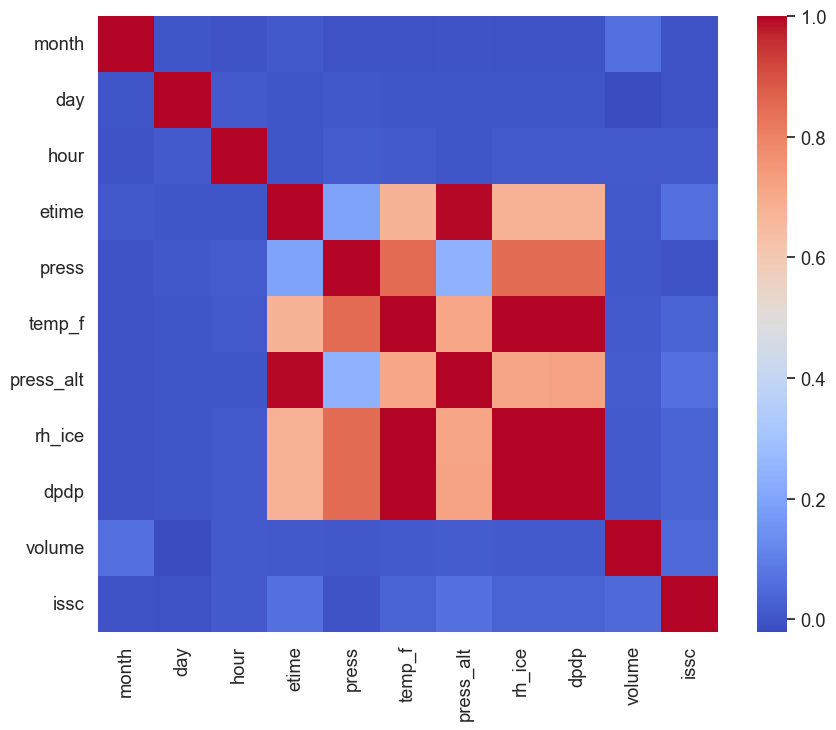

In [18]:
# Plot correlation matrix as heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2) 

sns.heatmap(data.corr(), fmt='.2f', cmap='coolwarm')

## Time Series Modeling

In [19]:
#Create DataFrame with volume column. Volume is based off of the number of times per day that an issc was yes
df['date'] = pd.to_datetime(df['date'])
issc_counts_per_day = df[df['issc'] == 1].groupby(df['date'].dt.date).size()
all_dates = pd.DataFrame(index=pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D'))
issc_counts_per_day.name = 'volume'
new_df = all_dates.join(issc_counts_per_day, how='left').fillna(0)

In [20]:
new_df

,volume
2022-01-01,0.0
2022-01-02,1.0
2022-01-03,0.0
2022-01-04,0.0
2022-01-05,0.0
...,...
2023-12-27,1.0
2023-12-28,0.0
2023-12-29,0.0
2023-12-30,3.0


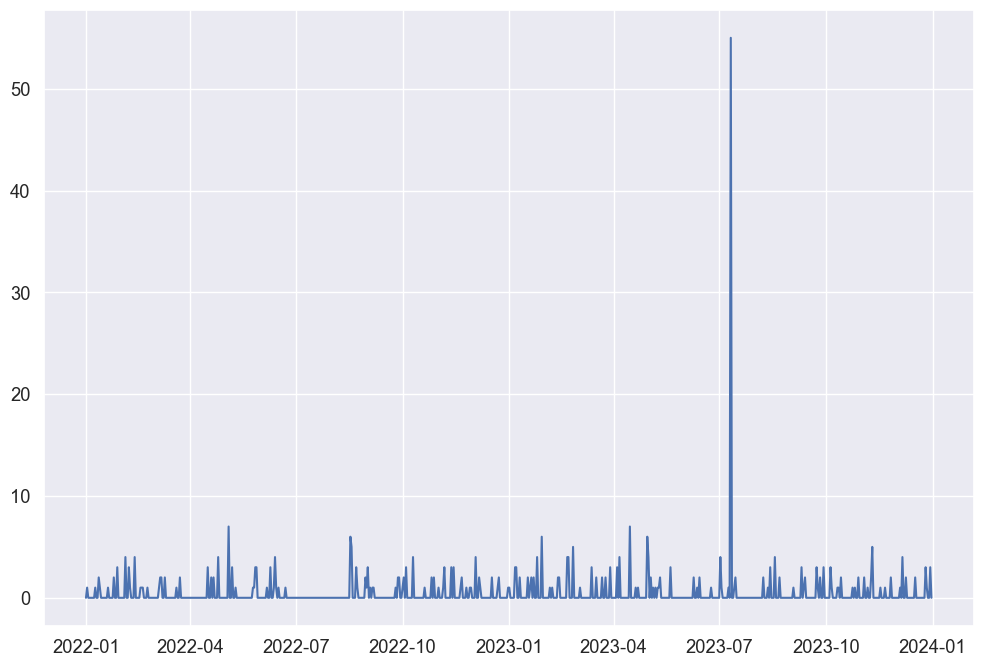

In [21]:
plt.figure(figsize = (12, 8))
plt.plot(new_df['volume'])

Analysis: There is a large outlier on July 11, 2023. This needs to be removed to output a more accurate time series model. 

### Autoregressive Integrated Moving Average (ARIMA) Model

In [22]:
new_df.drop('2023-07-11', inplace = True)

In [23]:
#Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Source: https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp
#ARIMA is statistical analysis model that uses time series data to predict future trends. This model can predict
#future values based on past values. ARIMA parameters include:
#p: the number of lag observations in the model
#d: the number of times the raw observations are differenced
#q: the size of the moving average window
#The ARIMA model identifies the appropriate number of lags.

#Splitting Training and Testing set
train_size = int(0.8 * len(new_df))
train, test = new_df.iloc[:train_size], new_df.iloc[train_size:]

# Fit ARIMA model
#Order represents, p, d, q. 
model = ARIMA(train['volume'], order=(3,1,3))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

In [24]:
#Root Mean Squared Error is used to evaluate the model. RMSE takes the square root fo the average of the squared
#differences between the predicted values and the actual values.The lower the RMSE, the more accurate the model.
mse = mean_squared_error(test['volume'], predictions)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.9892988981850243


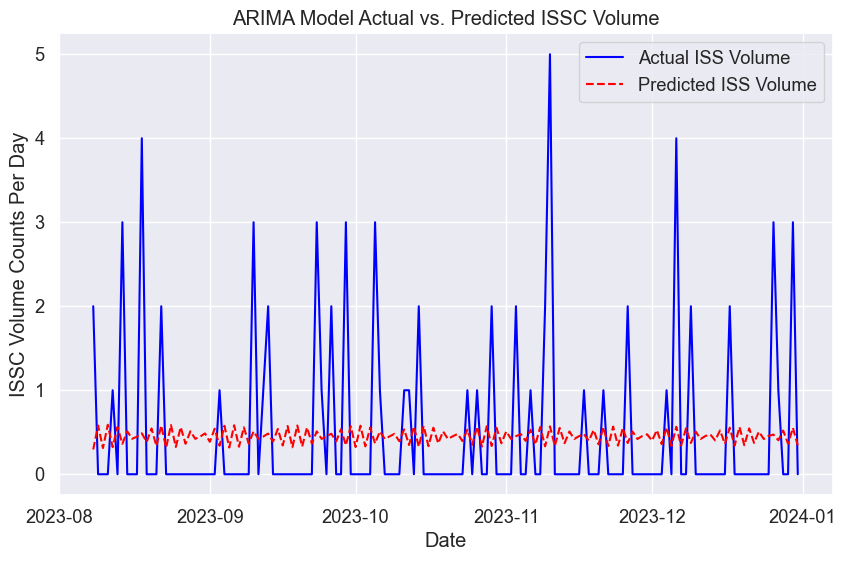

In [25]:
#Plotting Predicted versus Actual ISSC Volume Per Day
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['volume'], label='Actual ISS Volume', color='blue')
plt.plot(test.index, predictions, label='Predicted ISS Volume', color='red', linestyle='--')
plt.title('ARIMA Model Actual vs. Predicted ISSC Volume')
plt.xlabel('Date')
plt.ylabel('ISSC Volume Counts Per Day')
plt.legend()
plt.grid(True)
plt.show()

Analysis: First attempt at ARIMA did not yield great results. Need to try different parameters.

### ARIMA Parameter Tuning

In [55]:
#Assign ARIMA Paramters
#Source: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
#Source: https://levelup.gitconnected.com/simple-forecasting-with-auto-arima-python-a3f651271965
p_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
d_values = range(0,3)
q_values = range(0,3)

In [60]:
#Function that evaluates the ARIMA Model

def eval_arima_model(train, test, p_values, d_values, q_values):
    #Save best mse score, best parameters, and predictions made
    best_score, best_param, predict = float("inf"), None, float("inf")
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(train['volume'], order=(p, d, q))
                    model_fit = model.fit()
                    # Make predictions
                    predictions = model_fit.forecast(steps=len(test))
                    mse = (mean_squared_error(test['volume'], predictions))
                    print("The parameters p:", p, ", d:", d, ", q:", q, ". MSE =", mse)
                    #If mse is lower than the current best mse score, add that as the new mse
                    if mse < best_score:
                        best_score, best_param, predict = mse, order, predictions
                except:
                    continue
    print("Best ARIMA MSE Score =", best_score, best_param)
    
    #Plotting Predicted versus Actual ISSC Volume Per Day
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['volume'], label='Actual ISS Volume', color='blue')
    plt.plot(test.index, predict, label='Predicted ISS Volume', color='red', linestyle='--')
    plt.title('ARIMA Model Actual vs. Predicted ISSC Volume')
    plt.xlabel('Date')
    plt.ylabel('ISSC Volume Counts Per Day')
    plt.legend()
    plt.grid(True)
    plt.show()

The parameters p: 0 , d: 0 , q: 0 . MSE = 0.9901070856942309
The parameters p: 0 , d: 0 , q: 1 . MSE = 0.9906419135530118
The parameters p: 0 , d: 0 , q: 2 . MSE = 0.9902975906236035
The parameters p: 0 , d: 1 , q: 0 . MSE = 1.2191780821917808
The parameters p: 0 , d: 1 , q: 1 . MSE = 0.9901068046001588
The parameters p: 0 , d: 1 , q: 2 . MSE = 0.9906577422211205
The parameters p: 0 , d: 2 , q: 0 . MSE = 1.2191780821917808
The parameters p: 0 , d: 2 , q: 1 . MSE = 1.2191900220490832
The parameters p: 0 , d: 2 , q: 2 . MSE = 2.1884510809176247
The parameters p: 1 , d: 0 , q: 0 . MSE = 0.9906009780174189
The parameters p: 1 , d: 0 , q: 1 . MSE = 0.990555337869599
The parameters p: 1 , d: 0 , q: 2 . MSE = 0.9903062069540742
The parameters p: 1 , d: 1 , q: 0 . MSE = 1.2191780821917808
The parameters p: 1 , d: 1 , q: 1 . MSE = 0.9906188259832365
The parameters p: 1 , d: 1 , q: 2 . MSE = 0.9949001692532466
The parameters p: 1 , d: 2 , q: 0 . MSE = 1.2191780821917808
The parameters p: 1 , d: 

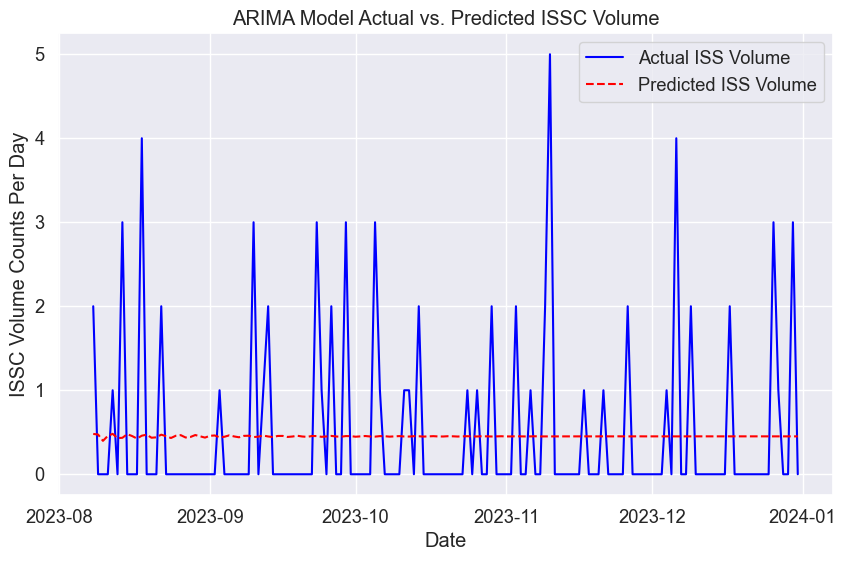

In [61]:
#Call function
eval_arima_model(train, test, p_values, d_values, q_values)

### Long Short Term Momory (LSTM)

In [26]:
#Source: https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/
#Source: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
#LSTM is an improvement of Reccurent Neural Networks. LSTM has a memory cell, which holds information for an extended period,
#which allows the model to learn long-term dependencies. 

#Input the number of lag features
num_lags = 2

#Create loop to add lag features to dataframe
for i in range(1, num_lags + 1):
    new_df[f'volume_lag{i}'] = new_df['volume'].shift(i)
    
# Fill missing values with 0
new_df['volume_lag1'] = new_df['volume_lag1'].fillna(0)
new_df['volume_lag2'] = new_df['volume_lag2'].fillna(0)

In [27]:
new_df

,volume,volume_lag1,volume_lag2
2022-01-01,0.0,0.0,0.0
2022-01-02,1.0,0.0,0.0
2022-01-03,0.0,1.0,0.0
2022-01-04,0.0,0.0,1.0
2022-01-05,0.0,0.0,0.0
...,...,...,...
2023-12-27,1.0,3.0,0.0
2023-12-28,0.0,1.0,3.0
2023-12-29,0.0,0.0,1.0
2023-12-30,3.0,0.0,0.0


In [28]:
#Input x and y variables
X1 = new_df[['volume_lag1', 'volume_lag2']].values
y1 = new_df['volume'].values

#LSTM model
#Units = Dimensionality of the output space
#Activation = Activation Function, using relu, which is rectified linear unit
#Input_Shape: The shape of the input data that will be inputted into the LSTM
#Dense: A 1 in Dense specifies that there is only one desired output. 
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X1.shape[1], 1)),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Fit model. 
#Epoch is the amount fo times we pass the entire trainign set through the neural network
#Batch_size is the number of training samples per iteration
#Verbose displays information while the model runs
model.fit(X1, y1, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
23/23 [==============================] - 2s 3ms/step - loss: 1.3245
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 1.2689
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 1.2262
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1949
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1730
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1528
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1420
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1330
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1278
Epoch 10/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1260
Epoch 11/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1248
Epoch 12/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1243
Epoch 13/100
23/23 [=================

23/23 [==============================] - 0s 2ms/step


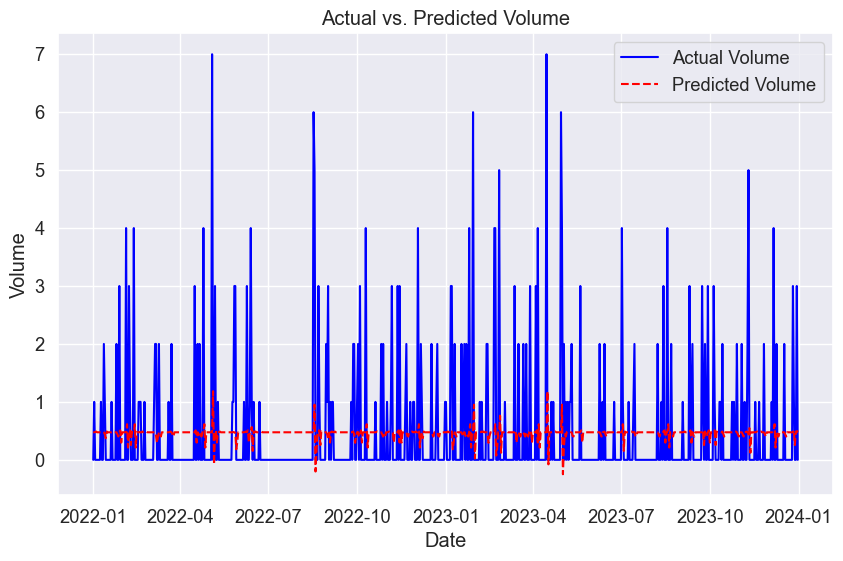

In [29]:
#Plotting actual vs. predicted issc volumes each day
actual_volume = new_df['volume']
predicted_volume = model.predict(X1)

# Plot actual vs. predicted volumes
plt.figure(figsize=(10, 6))
plt.plot(actual_volume.index, actual_volume, label='Actual Volume', color='blue')
plt.plot(actual_volume.index, predicted_volume, label='Predicted Volume', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Actual vs. Predicted Volume')
plt.legend()
plt.grid(True)
plt.show()

### Predicting the volume of issc for the next calandar day

In [30]:
#Extrating the last two volume lag variables
latest_volume_lag1 = new_df[['volume_lag1', 'volume_lag2']].iloc[-1]

# Reshape the input data
#Convert into an array
X_pred = np.array([latest_volume_lag1])
#Reshape the X_pred into the proper format for LSTM which is number of samples, number of timesteps, and number of features
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

# Make prediction
predicted_volume = model.predict(X_pred)

#Get the last date
latest_date = new_df.index[-1].date()

#Calculate the day we are predicitng for
next_date = latest_date + pd.DateOffset(days= 1)

#Outputting prediction
print(f"Predicted volume for {next_date}:", predicted_volume[0][0])

1/1 [==============================] - 0s 179ms/step
Predicted volume for 2024-01-01 00:00:00: 0.50873625


Analysis: In this preliminary LSTM model, we are recieiving a high loss rate (difference between predicted and actual values) of 5.1436. This is likely due to an outlier in the data, which is skewing the loss rate.

### LSTM with Removing Outlier

As shown in the last chart, there is an outlier in the data, which is causing the high loss rate. We will try again after removing the outlier from the dataset. 

In [31]:
#Removing outlier
outlier_df = new_df[new_df.index != '2023-07-11']

In [32]:
outlier_df

,volume,volume_lag1,volume_lag2
2022-01-01,0.0,0.0,0.0
2022-01-02,1.0,0.0,0.0
2022-01-03,0.0,1.0,0.0
2022-01-04,0.0,0.0,1.0
2022-01-05,0.0,0.0,0.0
...,...,...,...
2023-12-27,1.0,3.0,0.0
2023-12-28,0.0,1.0,3.0
2023-12-29,0.0,0.0,1.0
2023-12-30,3.0,0.0,0.0


In [33]:
#Fitting model
X2 = outlier_df[['volume_lag1', 'volume_lag2']].values
y2 = outlier_df['volume'].values

model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X2.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(X2, y2, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
23/23 [==============================] - 1s 3ms/step - loss: 1.3092
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 1.2512
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 1.2085
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1797
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1588
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1451
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1339
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1306
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1265
Epoch 10/100
23/23 [==============================] - 0s 4ms/step - loss: 1.1261
Epoch 11/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1261
Epoch 12/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1252
Epoch 13/100
23/23 [=================

### LSTM Remove Outlier and Create Train and Test sets

In [34]:
#This is where we incorporate train and test to validate how well the model is performing. 
# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Fit model on training data
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate model on testing data
loss = model.evaluate(X_test, y_test)
print('Testing Loss:', loss)

Epoch 1/50
19/19 [==============================] - 0s 4ms/step - loss: 1.2350
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 1.2352
Epoch 3/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2309
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 1.2351
Epoch 5/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2328
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2359
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2344
Epoch 8/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2346
Epoch 9/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2327
Epoch 10/50
19/19 [==============================] - 0s 4ms/step - loss: 1.2325
Epoch 11/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2324
Epoch 12/50
19/19 [==============================] - 0s 4ms/step - loss: 1.2331
Epoch 13/50
19/19 [==============================

23/23 [==============================] - 0s 2ms/step


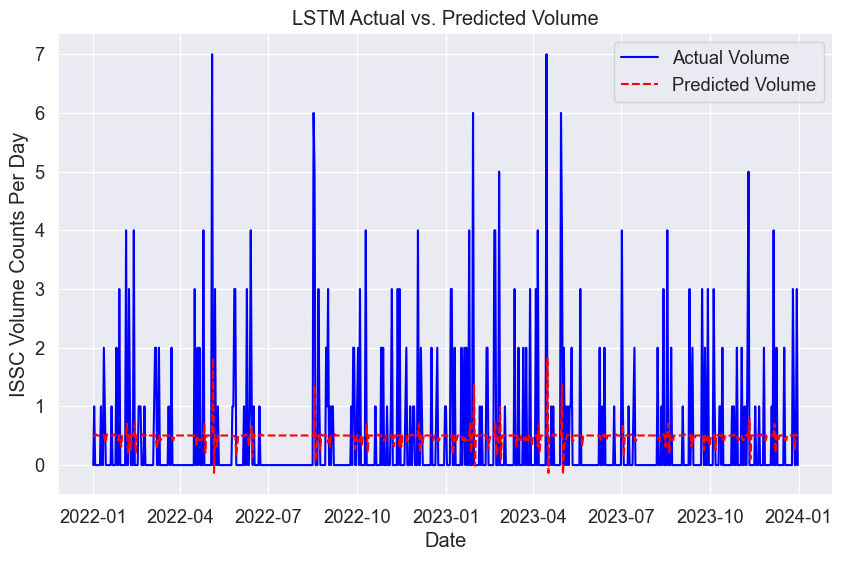

In [35]:
#Plotting actual vs. predicted issc volumes each day
actual_volume = outlier_df['volume']
predicted_volume = model.predict(X2)

# Plot actual vs. predicted volumes
plt.figure(figsize=(10, 6))
plt.plot(actual_volume.index, actual_volume, label='Actual Volume', color='blue')
plt.plot(actual_volume.index, predicted_volume, label='Predicted Volume', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('ISSC Volume Counts Per Day')
plt.title('LSTM Actual vs. Predicted Volume')
plt.legend()
plt.grid(True)
plt.show()

### Predicting the volume of issc for the next calandar day

In [36]:
latest_volume_lag12 = outlier_df[['volume_lag1', 'volume_lag2']].iloc[-1]
# Reshape the input data
X_pred = np.array([latest_volume_lag12])
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

# Make predictions
predicted_volume = model.predict(X_pred)

#Get the last date
latest_date = new_df.index[-1].date()

#Calculate the day we are predicitng for
next_date = latest_date + pd.DateOffset(days= 1)

print(f"Predicted volume for {next_date}:", predicted_volume[0][0])

1/1 [==============================] - 0s 180ms/step
Predicted volume for 2024-01-01 00:00:00: 0.50851333


Analysis: After removing the outlier, the LSTM model seems to perform better with bringing the training loss from 5.1436 to 1.2290. When analyzing the plot, appears to follow the actual volume decent, however, has trouble predicitng the extrme values. Although it may not guess if a day will have multiple instances of issc, it still might forecast the presence of at least 1. 

In [37]:
#Need to determine the optimal parameters and number of lag variables